In [1]:
import pickle
import numpy as np

bsnipdir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/BSNIP/'
bsnipdemo = pickle.load(open(f'{bsnipdir}/demographics.pkl', 'rb'))
bsniptopdir = '/home/anton/Documents/Tulane/Research/Work/ContrastiveLearning/BSNIP/'

fc = []
aps20 = []
aps15 = []
aps10 = []
aps5 = []
aps3 = []
aps1 = []
age = []
sex = []
race = []
sz = []

for sub in bsnipdemo['Age_cal']:
    try:
        a = bsnipdemo['Age_cal'][sub]
        s = bsnipdemo['sex'][sub]
        r = bsnipdemo['Race'][sub]
        d = bsnipdemo['DXGROUP_1'][sub]
        if d not in ['NC', 'SZP']:
            continue
        if r not in ['AA', 'CA']:
            continue
        s = s == 's1.0'
        r = r == 'AA'
        d = d == 'SZP'
        age.append(a)
        sex.append(s)
        race.append(r)
        sz.append(d)
        fc.append(np.load(f'{bsnipdir}/fc/{sub}_task-unk_fc.npy'))
        aps20.append(np.load(f'{bsniptopdir}/Top20/{sub}_task-unktop20_fc.npy'))
        aps3.append(np.load(f'{bsniptopdir}/Top3/{sub}_task-unktop3_fc.npy'))
        aps1.append(np.load(f'{bsniptopdir}/Top1/{sub}_task-unktop1_fc.npy'))
    except:
        pass

age = np.stack(age)
sex = np.stack(sex).astype('int')
race = np.stack(race).astype('int')
sz = np.stack(sz).astype('int')
fc = np.stack(fc)
aps20 = np.stack(aps20)
aps1 = np.stack(aps1)

print([x.shape for x in [age, sex, race, sz, fc, aps20, aps1]])

[(405,), (405,), (405,), (405,), (405, 34716), (405, 34716), (405, 34716)]


In [2]:
# Mixup

from scipy.special import softmax

idcs = np.arange(len(fc))
subi = np.random.choice(idcs)
sexm = sex == sex[subi]
racem = race == race[subi]
szm = sz == sz[subi]
agem = 1/((age-age[subi])**2+1)

sexm = softmax(sexm.astype('float'))
racem = softmax(racem.astype('float'))
szm = softmax(szm.astype('float'))
agem = softmax(2*agem)

p = sexm*racem*szm*agem
p = p/np.sum(p)

print(sex[subi], race[subi], sz[subi], age[subi])

test = []
control = []
comps = []

for _ in range(10):
    i = np.random.choice(idcs, p=p)
    print(sex[i], race[i], sz[i], age[i])

    comps.append(i)
    control.append(fc[i])
    test.append(fc[subi]-0.8*aps1[subi]+0.8*aps1[i])

control = np.stack(control)
test = np.stack(test)

print(test.shape, control.shape)

1 1 1 46.0
0 1 1 46.0
0 1 1 40.0
1 1 1 25.0
0 1 1 51.0
1 1 1 53.0
1 1 1 45.0
1 0 0 20.0
1 0 1 20.0
1 1 1 22.0
0 1 0 30.0
(10, 34716) (10, 34716)


In [3]:
# Train on whole cohort

from sklearn.linear_model import LogisticRegression, Ridge

regs = LogisticRegression(max_iter=1000).fit(fc, sex)
print('Done sex')

regr = LogisticRegression(max_iter=1000).fit(fc, race)
print('Done race')

regd = LogisticRegression(max_iter=1000).fit(fc, sz)
print('Done sz')

rega = Ridge(alpha=1).fit(fc, age)
print('Done age')

Done sex
Done race
Done sz
Done age


In [4]:
print('Sex')

yhat = regs.predict_proba(test)
print(yhat[:,0])

yhat = regs.predict_proba(control)
print(yhat[:,0])

print('Race')

yhat = regr.predict_proba(test)
print(yhat[:,0])

yhat = regr.predict_proba(control)
print(yhat[:,0])

print('SZ')

yhat = regd.predict_proba(test)
print(yhat[:,0])

yhat = regd.predict_proba(control)
print(yhat[:,0])

print('Age')

yhat = rega.predict(test)
print(yhat)

yhat = rega.predict(control)
print(yhat)

Sex
[1.91466719e-01 2.13267673e-01 4.29183093e-05 9.38489487e-05
 4.54517433e-03 4.75885399e-03 4.97234200e-03 8.54935694e-04
 8.43140727e-03 1.42719338e-01]
[9.98550384e-01 9.96884840e-01 9.37112810e-04 9.94153260e-01
 4.48448885e-03 1.61445282e-03 6.16735465e-03 3.36698863e-03
 5.25820541e-03 9.93783295e-01]
Race
[0.00516429 0.00174389 0.02266942 0.01497267 0.00376417 0.02203139
 0.10513273 0.19262296 0.04476378 0.00313097]
[0.00282141 0.00400016 0.00681477 0.00315705 0.00493044 0.00824396
 0.99667591 0.99634314 0.00390845 0.00245394]
SZ
[2.94775343e-04 1.24259602e-03 2.77317396e-03 3.23221581e-05
 5.47387995e-05 1.04720756e-03 2.63171388e-02 5.83756568e-03
 5.86750707e-03 2.13123802e-02]
[4.46702647e-03 4.32638291e-03 3.92672302e-03 2.43025874e-05
 6.15884399e-04 4.09617191e-03 9.94858947e-01 8.73029109e-03
 2.35981586e-03 9.90584832e-01]
Age
[46.52894976 47.27411027 46.44390859 47.68061351 47.59834864 45.50398595
 42.51835227 40.31577413 41.02926504 43.09977089]
[45.9899353  40.006

In [2]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


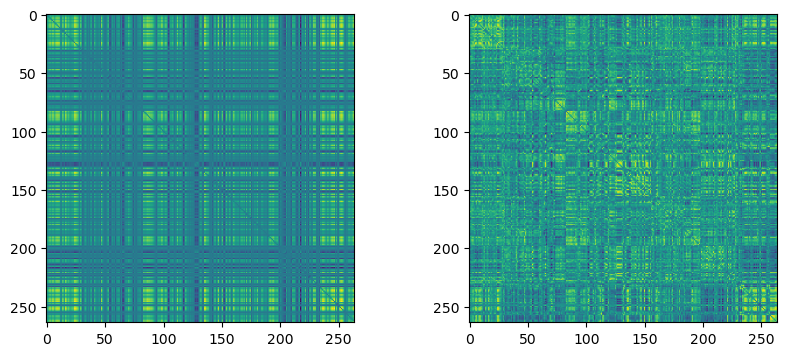

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].imshow(remap(vec2mat(aps1[3])))
ax[1].imshow(remap(vec2mat(fc[3])))

fig.show()
fig.savefig('/home/anton/Documents/Tulane/Research/Work/ContrastiveLearning/PDF/bsnip_sub3.pdf')

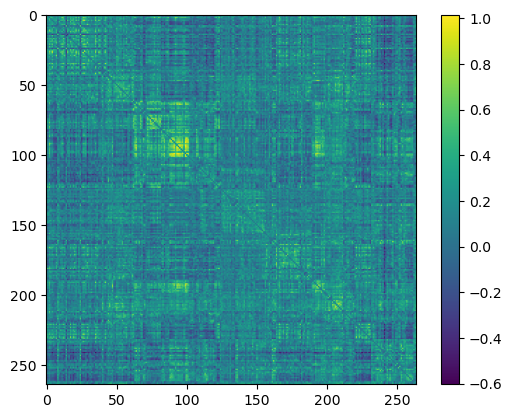

In [6]:
import matplotlib.pyplot as plt

plt.imshow(remap(vec2mat(test[7])))
plt.colorbar()
plt.show()

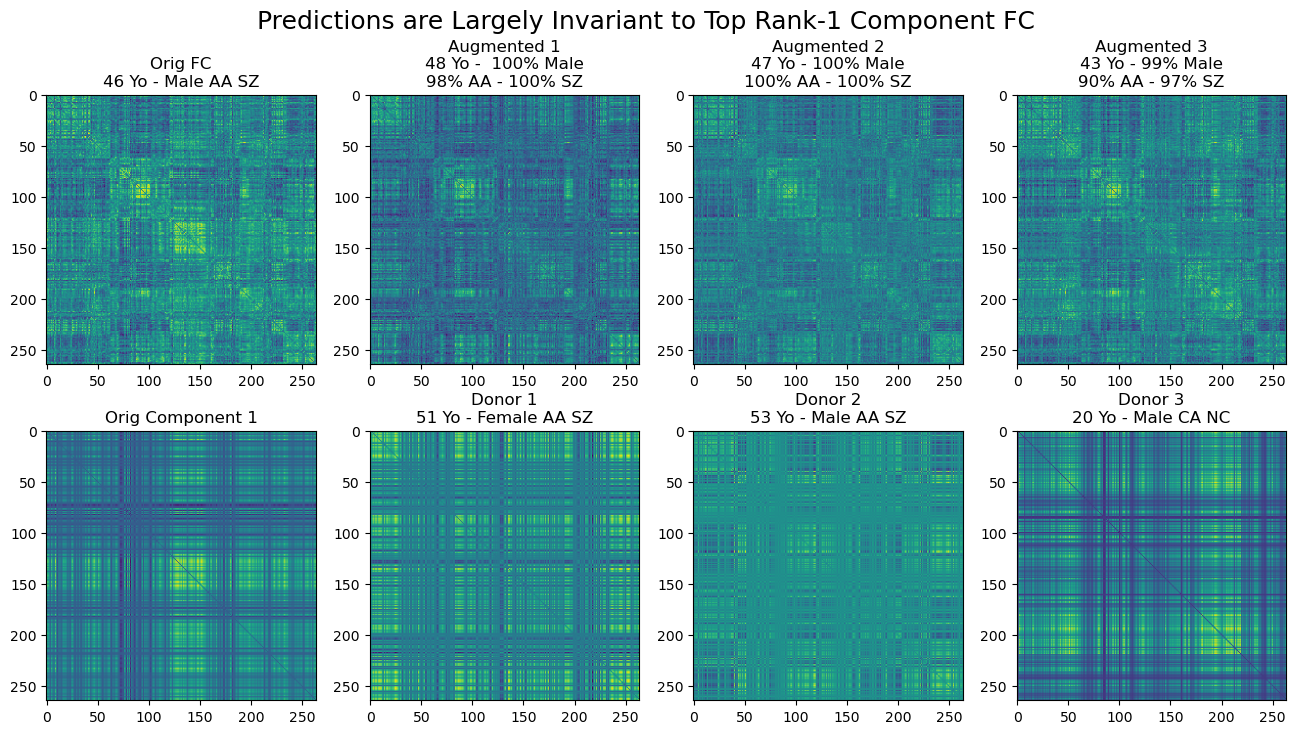

In [12]:
fig, ax = plt.subplots(2,4,figsize=(16,8))

ax[0,0].imshow(remap(vec2mat(fc[subi])))
ax[0,0].set_title('Orig FC\n46 Yo - Male AA SZ')

ax[1,0].imshow(remap(vec2mat(aps1[subi])))
ax[1,0].set_title('Orig Component 1')

ax[0,1].imshow(remap(vec2mat(test[3])))
ax[0,1].set_title('Augmented 1\n48 Yo -  100% Male\n98% AA - 100% SZ')

ax[0,2].imshow(remap(vec2mat(test[4])))
ax[0,2].set_title('Augmented 2\n47 Yo - 100% Male\n100% AA - 100% SZ')

ax[0,3].imshow(remap(vec2mat(test[6])))
ax[0,3].set_title('Augmented 3\n43 Yo - 99% Male\n90% AA - 97% SZ')

ax[1,1].imshow(remap(vec2mat(aps1[comps[3]])))
ax[1,2].imshow(remap(vec2mat(aps1[comps[4]])))
ax[1,3].imshow(remap(vec2mat(aps1[comps[6]])))

ax[1,1].set_title('Donor 1\n51 Yo - Female AA SZ')
ax[1,2].set_title('Donor 2\n53 Yo - Male AA SZ')
ax[1,3].set_title('Donor 3\n20 Yo - Male CA NC')

fig.suptitle('Predictions are Largely Invariant to Top Rank-1 Component FC', fontsize=18)
fig.show()
fig.savefig('/home/anton/Documents/Tulane/Research/Work/ContrastiveLearning/augmentations.pdf')

In [308]:
from sklearn.model_selection import train_test_split

accs = []

for _ in range(20):
    xtr, xt, ytr, yt, ztr, zt = train_test_split(fc, race, aps1, stratify=race, train_size=0.5)

    xtr2 = []
    ytr2 = []
    
    # Make 5 mixup subs per train sub
    for i in range(len(xtr)):
        idcs = np.random.choice(np.arange(len(xtr)), size=10)
        for j in idcs:
            xtr2.append(xtr[i]-0.5*ztr[i]+0.5*ztr[j])
            ytr2.append(ytr[i])

    xtr2 = np.stack(xtr2)
    ytr2 = np.array(ytr2)

    reg = LogisticRegression(max_iter=1000).fit(xtr2, ytr2)
    yhat = reg.predict(xt)
    acc = np.mean(yhat == yt)
    accs.append(acc)
    print(acc)
    
print(np.mean(accs), np.std(accs))

0.7733990147783252
0.7241379310344828
0.6995073891625616
0.7339901477832512
0.7586206896551724
0.7684729064039408
0.7536945812807881
0.7635467980295566
0.7389162561576355
0.7142857142857143
0.7783251231527094
0.7142857142857143
0.7487684729064039
0.729064039408867
0.7339901477832512
0.7142857142857143
0.7438423645320197
0.7684729064039408
0.7438423645320197
0.7241379310344828
0.7413793103448276 0.0220026713636722


In [291]:
np.mean(yhat == yt)

0.6551724137931034

In [ ]:
0.6492610837438424 0.014579949346747539
---
0.6839506172839506 0.050662430935020215
0.6925925925925924 0.051630922632904905
---
Race
Reg 0.7266009852216749 0.024605899002447626
Reg 0.7359605911330049 0.033678156916526515
Reg 0.7337438423645319 0.018463051558532173
Augx5 0.7458128078817734 0.025473267928764327
Augx5 0.7399014778325123 0.018471264294830196
Augx10 0.746551724137931 0.023751557318244618
Augx10 0.7413793103448276 0.0220026713636722